In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score,classification_report,make_scorer

import shap
import dataframe_image as dfi
import cv2

In [53]:
df_train = pd.read_csv('../Data/training_benchmark.csv',header=None)
df_test = pd.read_csv('../Data/testing_benchmark.csv',header=None)

df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train=df_train.dropna()
df_train=df_train.fillna(method="ffill")
df_train = df_train.apply(pd.to_numeric,errors="coerce")

df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test=df_test.dropna()
df_test=df_test.fillna(method="ffill")
df_test = df_test.apply(pd.to_numeric,errors="coerce")

df_train = df_train.drop([0],axis = 1)
df_test = df_test.drop([0],axis = 1)

In [54]:
df_train = df_train.drop_duplicates(keep='first').reset_index(drop=True)
df_test = df_test.drop_duplicates(keep='first').reset_index(drop=True)

global numerical_features_train, numerical_features_test
numerical_features_train = list(df_train.select_dtypes(exclude=['object']).columns)
numerical_features_test = list(df_test.select_dtypes(exclude=['object']).columns)

In [55]:
scaled_enc_df_train = df_train.copy()
scaled_enc_df_test = df_test.copy()

col_names = numerical_features_train
features = scaled_enc_df_train[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_enc_df_train[col_names] = features

col_names = numerical_features_test
features = scaled_enc_df_test[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_enc_df_test[col_names] = features

In [57]:
scaled_enc_df_train.columns[-1]

79

In [58]:
def MI_topk_features(df_pp, k):

    now = datetime.now()
    print(f'{now} - Mutual Information feature selection Initialized..')

    X = df_pp.iloc[:,:-1]
    y = df_pp.iloc[:,-1]

    importances = mutual_info_classif(X,y)
    feature_imp = pd.Series(importances, df_pp.columns[0:len(df_pp.columns)-1])

    MI_features = list(feature_imp.sort_values(ascending = False)[:k].index)

    now = datetime.now()
    print(f'{now} - Mutual Information feature selection Successful!')

    return MI_features

def CORR_topk_features(df_pp, k):

    now = datetime.now()
    print(f'{now} - Correlation feature selection Initialized..')

    cor = df_pp.corr()
    CORR_features = list(abs(cor[79]).sort_values(ascending=False)[:k+1].index)
    CORR_features.remove(79)

    now = datetime.now()
    print(f'{now} - Correlation feature selection Successful!')

    return CORR_features

def RFFI_topk_features(df_pp, k):
    
    now = datetime.now()
    print(f'{now} - RF Feature Importance feature selection Initialized..')

    X = df_pp.iloc[:,:-1]
    y = df_pp.iloc[:,-1]

    rf = RandomForestClassifier(n_estimators=200,random_state=42)
    rf.fit(X.values,y.values)
    rffi = rf.feature_importances_

    features = pd.Series(rffi, df_pp.columns[0:len(df_pp.columns)-1])
    RFFI_features = list(features.sort_values(ascending = False)[:k].index)

    now = datetime.now()
    print(f'{now} - RF Feature Importance feature selection Successful!')

    return RFFI_features

def SHAP_topk_features(df_train, df_test, number_of_instances, k):

    now = datetime.now()
    print(f'{now} - SHAP feature selection Initialized!')

    train_X =  df_train.iloc[:,:-1]
    test_X = df_test.iloc[:,:-1]
    train_y = df_train.iloc[:,-1]
    test_y = df_test.iloc[:,-1]

    rf = RandomForestClassifier(random_state=42).fit(train_X.values,train_y.values)
    shap_df = pd.DataFrame()

    for target in list(train_y.value_counts().index):   
        target = int(target)
        i = []
        v = []

        for index, value in zip(range(len(train_y)), train_y):    
            i.append(index)
            v.append(value)
        
        y_val = pd.Series(v,i)
        y_val = list(y_val[y_val==target].index)

        idx_threshold = number_of_instances
        final_idx = []

        for idx in y_val:
            if idx_threshold > 0:
                row_instance = train_X.iloc[idx]
                row_pred = row_instance.values.reshape(1, -1)

                if float(rf.predict_proba(row_pred)[0][target]) == 1.0:
                    final_idx.append(idx)
                    idx_threshold = idx_threshold - 1
            else:
                break

        temp_df = pd.DataFrame()

        for idx in final_idx:
            row_instance = train_X.iloc[idx]
            row_pred = row_instance.values.reshape(1, -1)
            
            explainer = shap.TreeExplainer(rf)
            shap_values = explainer.shap_values(row_instance)

            series_idx = row_instance.index
            series_val = shap_values[target]

            feature_series = pd.Series(series_val, series_idx)
            
            shap_df_temp = feature_series.to_frame().rename(columns={0:'shap_value'}).rename_axis('features').reset_index()
            temp_df = temp_df.append(shap_df_temp, ignore_index = True)

        temp_df = temp_df.sort_values(by=['shap_value'], ascending=False).drop_duplicates(subset='features', keep='first')
        shap_df = shap_df.append(temp_df, ignore_index = True)    

    shap_df = shap_df.sort_values(by=['shap_value'], ascending=False).drop_duplicates(subset='features', keep='first')
    shap_features = list(shap_df['features'].iloc[:k])

    now = datetime.now()
    print(f'{now} - SHAP feature selection Successful!')

    return shap_features

In [62]:
def model_performance(df_train, df_test, features, technique, k, atype='', dataset='UNSW'):

    now = datetime.now()
    print(f'{now} - Model training started!')

    train_X =  df_train[features]
    test_X = df_test[features]
    train_y = df_train.iloc[:,-1]
    test_y = df_test.iloc[:,-1]

    scorer = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average = 'macro', zero_division = 1),
            'recall': make_scorer(recall_score, average = 'weighted'),
            'f1': make_scorer(f1_score, average = 'weighted')
                }

    param_grid = { 
            'n_estimators': [200, 300, 400],
            'max_depth' : [6,7,8,9,10],
            'criterion' : ['entropy']
    }

    clf = RandomForestClassifier(random_state = 42)

    g_search = RandomizedSearchCV(estimator = clf, 
                            param_distributions = param_grid, 
                            cv = 3, 
                            n_jobs = -1, 
                            scoring=scorer,
                            refit='f1')

    g_search.fit(train_X, train_y)

    n_estimators = g_search.best_params_['n_estimators']
    max_depth = g_search.best_params_['max_depth']
    criterion = g_search.best_params_['criterion']


    clf=RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, random_state=42)
    clf.fit(train_X.values,train_y.values)
    y_pred=clf.predict(test_X)

    plot_confusion_matrix(clf, test_X, test_y)
    plt.title(f"{technique}_Confusion_Matrix")
    plt.savefig(f"visualization/Figures/{dataset}_{atype}_k{str(k)}_{str(technique)}_Confusion_Matrix.png", dpi=300, bbox_inches='tight')
    
    sk_report = classification_report(
    digits=6,
    y_true=test_y, 
    y_pred=y_pred,
    output_dict=True)

    report_df = pd.DataFrame(sk_report).transpose()
    
    filename = "visualization/Figures/"+dataset+'_'+atype+"_k"+str(k)+'_'+str(technique)+"_Performance_Report" + ".png"
    dfi.export(report_df,filename)

    performance_dictionary={'Technique':[], 'Class':[],'Accuracy':[],'F1_Score':[],'Precision':[],'Recall':[], 'HP_n_estimators':[], 'HP_max_depth':[], 'k':[]}

    f1 = list(f1_score(test_y, y_pred, average=None))
    matrix = confusion_matrix(test_y, y_pred)
    acc = list(matrix.diagonal()/matrix.sum(axis=1))
    pr = list(precision_score(test_y, y_pred, average=None))
    rl = list(recall_score(test_y, y_pred, average=None))

    for i in range(len(f1)):
        performance_dictionary['Technique'].append(technique)
        performance_dictionary['Class'].append(i)
        performance_dictionary['Accuracy'].append(acc[i])
        performance_dictionary['F1_Score'].append(f1[i])
        performance_dictionary['Precision'].append(pr[i])
        performance_dictionary['Recall'].append(rl[i])
        performance_dictionary['HP_n_estimators'].append(n_estimators)
        performance_dictionary['HP_max_depth'].append(max_depth)
        performance_dictionary['k'].append(k)
        

    df = pd.DataFrame.from_dict(performance_dictionary)

    now = datetime.now()
    print(f'{now} - Model performance dataframe created Successfully!')

    return df

In [63]:
def Binary_Performance_BarChart(MI_perf_df, CORR_perf_df, RFFI_perf_df, SHAP_perf_df, metric,k,dataset='KDDCUP'):

    now = datetime.now()
    print(f'{now} - Initializing {str.upper(metric)} Binary comparision Bar Chart visualization..')

    plt.rcParams['figure.dpi'] = 150
    X = ['Normal','Anomaly']
    
    MI_acc = list(MI_perf_df[metric])
    CORR_acc = list(CORR_perf_df[metric])
    RFFI_acc = list(RFFI_perf_df[metric])
    SHAP_acc = list(SHAP_perf_df[metric])

    df = pd.DataFrame({'MI_acc': MI_acc,
                   'CORR_acc': CORR_acc,
                   'RFFI_acc': RFFI_acc,
                   'SHAP_acc': SHAP_acc
                   }, index=X)
    ax = df.plot.bar(rot=0)

    plt.title(str.upper(metric) + ' PERFORMANCE')
    plt.legend()
    plt.savefig(f"visualization/Figures/{dataset}_Binary_k{str(k)}_{metric}_Bar.png", dpi=300, bbox_inches='tight')

    now = datetime.now()
    print(f'{now} - {str.upper(metric)} BinaryClass comparision bar chart visualization generated Successfully!')

def Binary_Performance_ScatterChart(MI_perf_df, CORR_perf_df, RFFI_perf_df, SHAP_perf_df, metric,k,dataset):

    now = datetime.now()
    print(f'{now} - Initializing {str.upper(metric)} BinaryClass comparision Scatter Chart visualization..')

    plt.rcParams['figure.dpi'] = 150
    
    X = ['Normal','Anomaly']
    
    SHAP = list(SHAP_perf_df[metric])
    MI = list(MI_perf_df[metric])
    CORR = list(CORR_perf_df[metric])
    RFFI = list(RFFI_perf_df[metric])
    
    df = pd.DataFrame({'CORR': CORR,
                   'RFFI': RFFI,
                   'SHAP': SHAP, 
                   'MI': MI,
                   'Class' : X
                   })
    c=['r','g','orange', 'purple']
    Y= ['CORR','RFFI','SHAP','MI']
    fig, ax = plt.subplots()

    for m in range(len(Y)):
        ax.scatter(x=df['Class'], y=df[Y[m]], color=c[m],label=df[Y[m]].name)    

    plt.xlabel('Class')
    plt.ylabel(metric)
    plt.title(str.upper(metric) + ' PERFORMANCE')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"visualization/Figures/{dataset}_Binary_k{str(k)}_{metric}_Scatter.png", dpi=300, bbox_inches='tight')


    now = datetime.now()
    print(f'{now} - {str.upper(metric)} BinaryClass comparision line chart visualization generated Successfully!')

def Binary_Summary_Plots(image1,image2, image3, image4, title_text,k,dataset):
    
    now = datetime.now()
    print(f'{now} - Initializing {title_text} BinaryClass summary plot..')

    plt.rcParams['figure.dpi'] = 150
    fig = plt.figure(figsize=(10, 7))
    rows = 2
    columns = 2
    
    Image1 = cv2.imread(image1)
    Image2 = cv2.imread(image2)
    Image3 = cv2.imread(image3)
    Image4 = cv2.imread(image4)
    
    fig.add_subplot(rows, columns, 1)
    
    plt.imshow(Image1)
    plt.axis('off')
        
    fig.add_subplot(rows, columns, 2)
    
    plt.imshow(Image2)
    plt.axis('off')
        
    fig.add_subplot(rows, columns, 3)
    
    plt.imshow(Image3)
    plt.axis('off')
        
    fig.add_subplot(rows, columns, 4)
    
    plt.imshow(Image4)
    plt.axis('off')
    
    plt.savefig(f"visualization/Figures_Summary/{dataset}_Binary_k{str(k)}_{title_text}_Summary_Plot.png", dpi=300, bbox_inches='tight')

    now = datetime.now()
    print(f'{now} - {title_text} BinaryClass summary plot completed!')

In [61]:
import warnings

  0%|          | 0/4 [00:00<?, ?it/s]

Starting the Length of Features - 40
2022-02-07 23:07:08.460053 - Mutual Information feature selection Initialized..
2022-02-07 23:08:31.036733 - Mutual Information feature selection Successful!
2022-02-07 23:08:31.043713 - Correlation feature selection Initialized..
2022-02-07 23:08:33.774606 - Correlation feature selection Successful!
2022-02-07 23:08:33.774606 - RF Feature Importance feature selection Initialized..
2022-02-07 23:09:16.340792 - RF Feature Importance feature selection Successful!
2022-02-07 23:09:16.346777 - SHAP feature selection Initialized!
2022-02-07 23:09:39.086800 - SHAP feature selection Successful!
2022-02-07 23:09:39.109489 - Model training started!
2022-02-07 23:17:04.708877 - Model performance dataframe created Successfully!
2022-02-07 23:17:04.708877 - Model training started!
2022-02-07 23:22:31.917744 - Model performance dataframe created Successfully!
2022-02-07 23:22:31.917744 - Model training started!
2022-02-07 23:28:57.684500 - Model performance data

 25%|██▌       | 1/4 [32:56<1:38:50, 1976.93s/it]

2022-02-07 23:40:05.387745 - Scatter_Chart BinaryClass summary plot completed!
---------------------------------------------------------------------------------------------
Starting the Length of Features - 28
2022-02-07 23:40:05.387745 - Mutual Information feature selection Initialized..
2022-02-07 23:44:04.844749 - Mutual Information feature selection Successful!
2022-02-07 23:44:04.844749 - Correlation feature selection Initialized..
2022-02-07 23:44:09.434089 - Correlation feature selection Successful!
2022-02-07 23:44:09.434089 - RF Feature Importance feature selection Initialized..
2022-02-07 23:45:00.508582 - RF Feature Importance feature selection Successful!
2022-02-07 23:45:00.508582 - SHAP feature selection Initialized!
2022-02-07 23:45:26.482419 - SHAP feature selection Successful!
2022-02-07 23:45:26.489404 - Model training started!
2022-02-07 23:53:56.048110 - Model performance dataframe created Successfully!
2022-02-07 23:53:56.056088 - Model training started!
2022-02-08

 50%|█████     | 2/4 [1:13:33<1:14:54, 2247.03s/it]

2022-02-08 00:20:41.492090 - Scatter_Chart BinaryClass summary plot completed!
---------------------------------------------------------------------------------------------
Starting the Length of Features - 20
2022-02-08 00:20:41.492090 - Mutual Information feature selection Initialized..
2022-02-08 00:22:44.713108 - Mutual Information feature selection Successful!
2022-02-08 00:22:44.713108 - Correlation feature selection Initialized..
2022-02-08 00:22:47.919235 - Correlation feature selection Successful!
2022-02-08 00:22:47.919235 - RF Feature Importance feature selection Initialized..
2022-02-08 00:23:36.473513 - RF Feature Importance feature selection Successful!
2022-02-08 00:23:36.473513 - SHAP feature selection Initialized!
2022-02-08 00:24:01.405227 - SHAP feature selection Successful!
2022-02-08 00:24:01.420842 - Model training started!
2022-02-08 00:29:04.227394 - Model performance dataframe created Successfully!
2022-02-08 00:29:04.258638 - Model training started!
2022-02-08

 75%|███████▌  | 3/4 [1:39:27<32:10, 1930.88s/it]  

2022-02-08 00:46:36.136288 - Scatter_Chart BinaryClass summary plot completed!
---------------------------------------------------------------------------------------------
Starting the Length of Features - 11
2022-02-08 00:46:36.151912 - Mutual Information feature selection Initialized..
2022-02-08 00:48:22.183399 - Mutual Information feature selection Successful!
2022-02-08 00:48:22.183399 - Correlation feature selection Initialized..
2022-02-08 00:48:27.253211 - Correlation feature selection Successful!
2022-02-08 00:48:27.253211 - RF Feature Importance feature selection Initialized..
2022-02-08 00:50:19.632092 - RF Feature Importance feature selection Successful!
2022-02-08 00:50:19.632092 - SHAP feature selection Initialized!
2022-02-08 00:51:18.990281 - SHAP feature selection Successful!
2022-02-08 00:51:18.990281 - Model training started!
2022-02-08 00:57:05.603039 - Model performance dataframe created Successfully!
2022-02-08 00:57:05.618658 - Model training started!
2022-02-08

100%|██████████| 4/4 [2:00:26<00:00, 1806.58s/it]

2022-02-08 01:07:34.773844 - Scatter_Chart BinaryClass summary plot completed!
---------------------------------------------------------------------------------------------


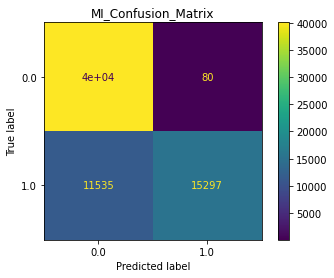

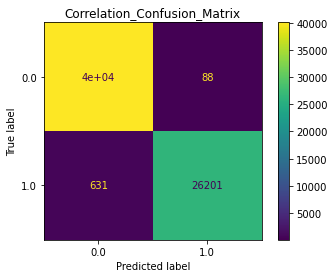

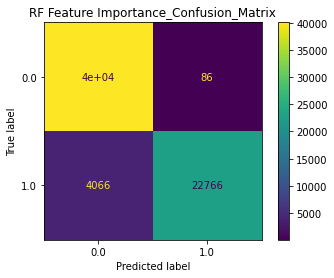

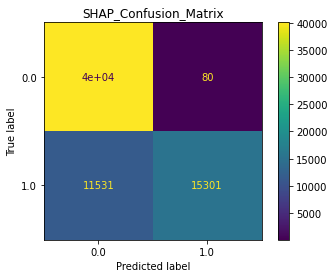

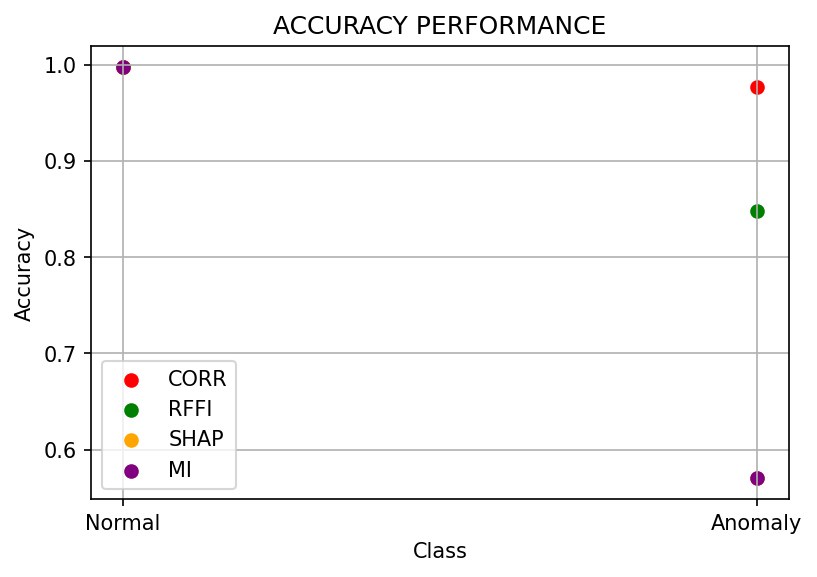

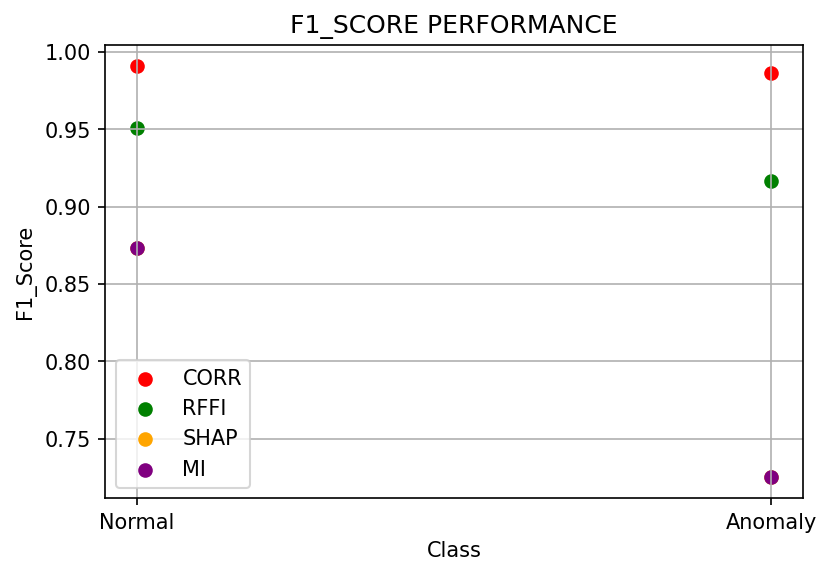

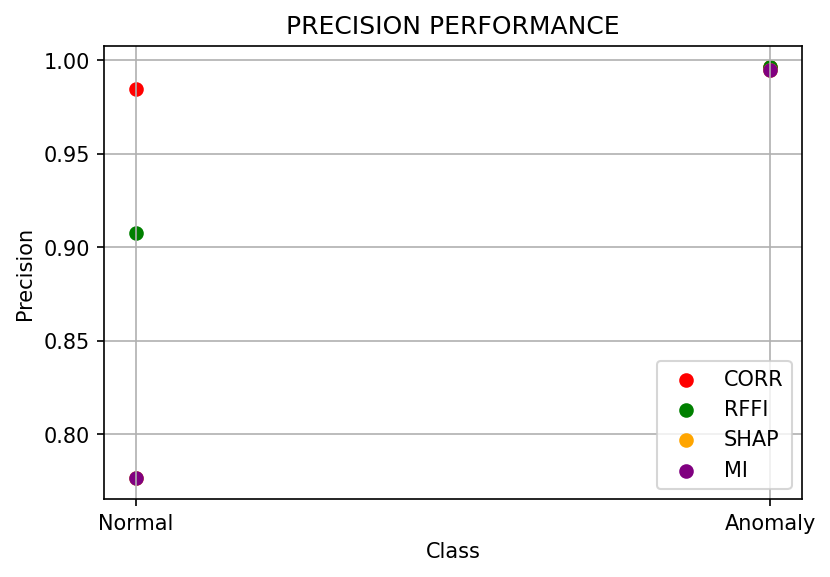

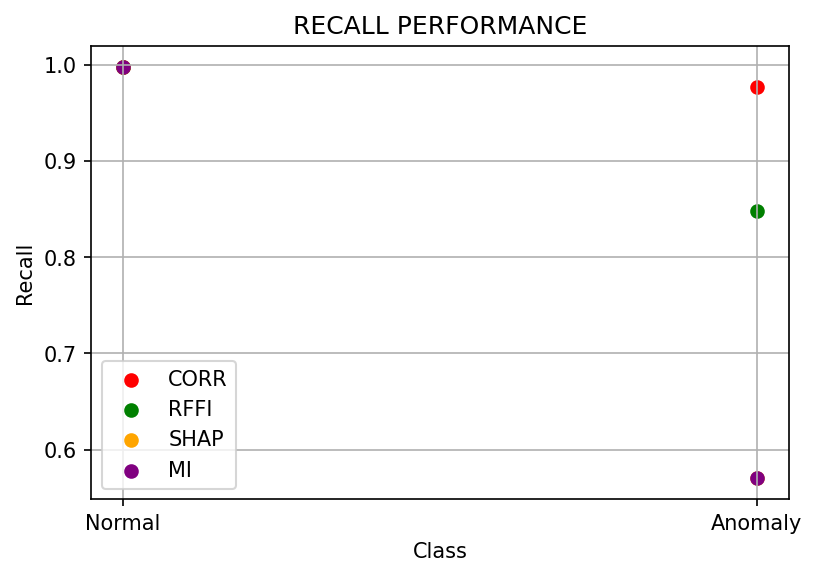

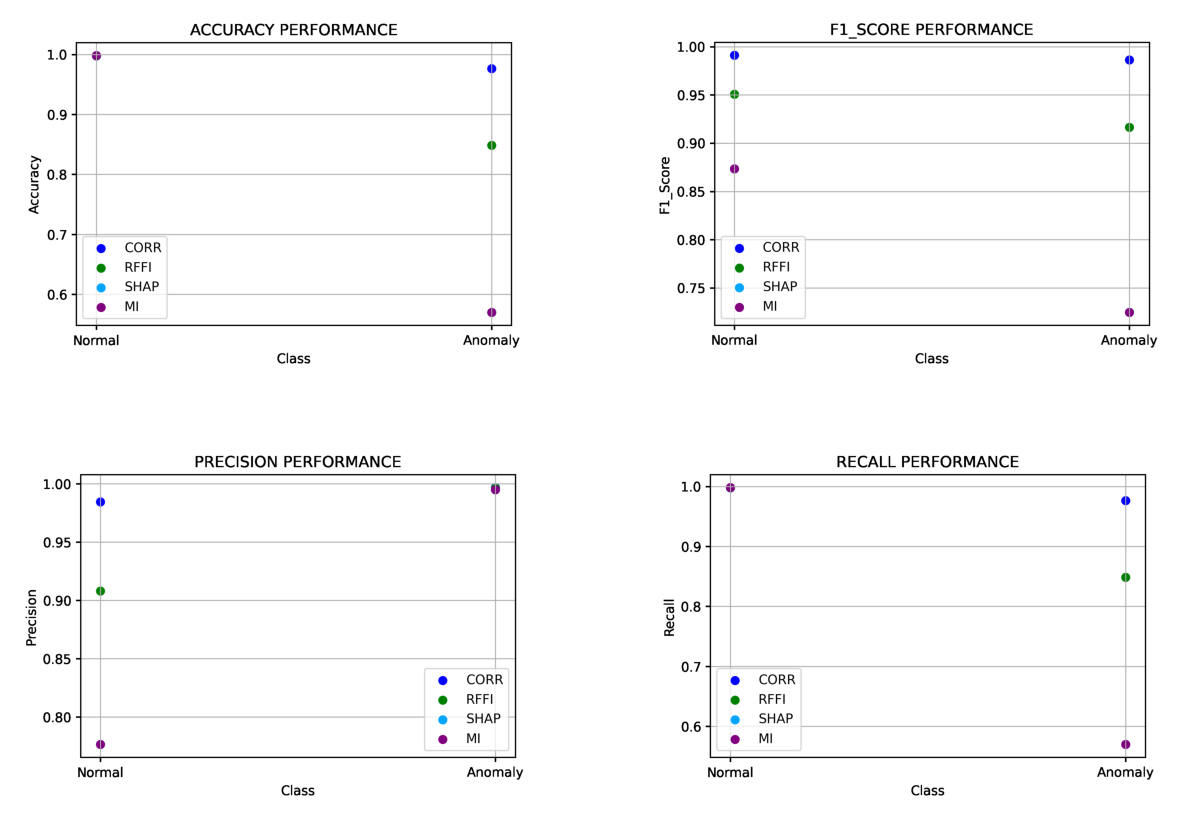

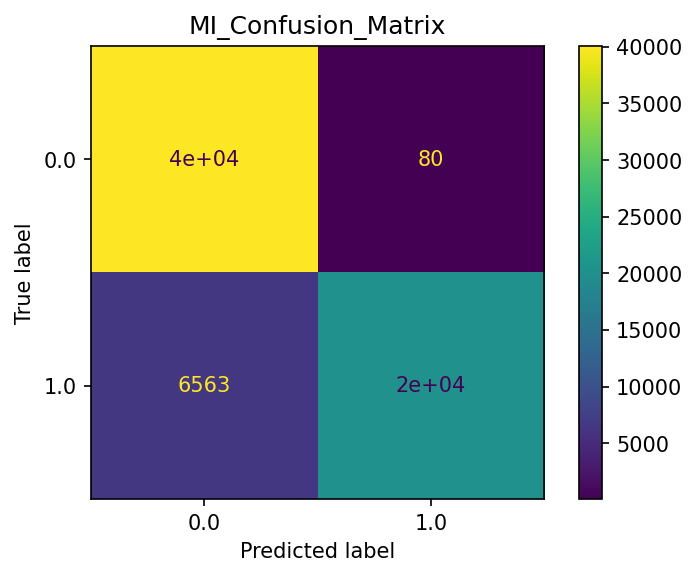

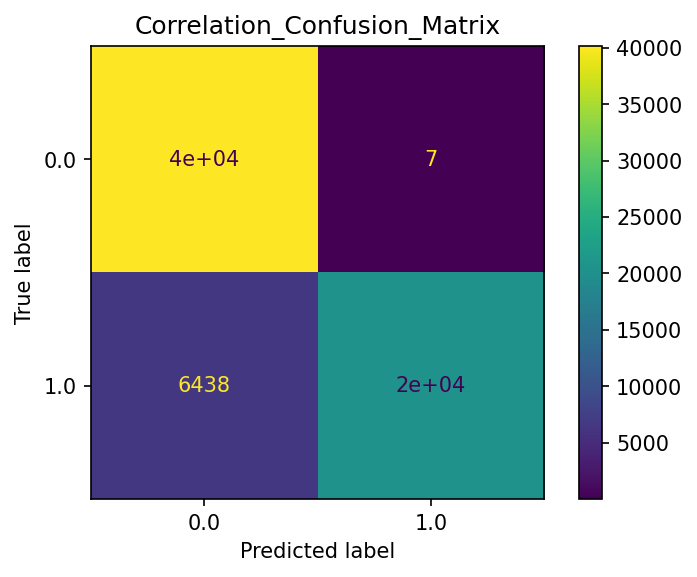

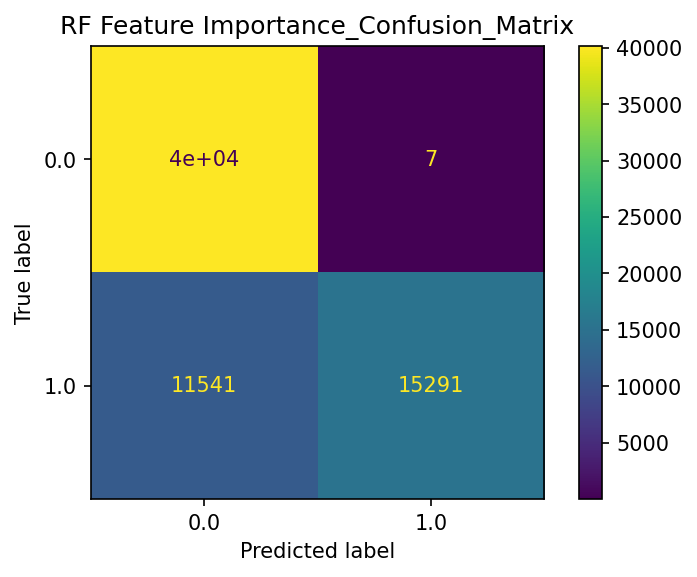

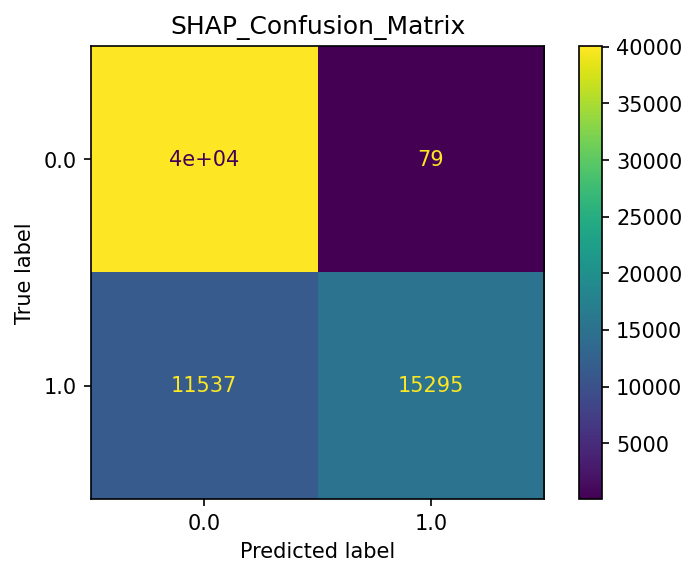

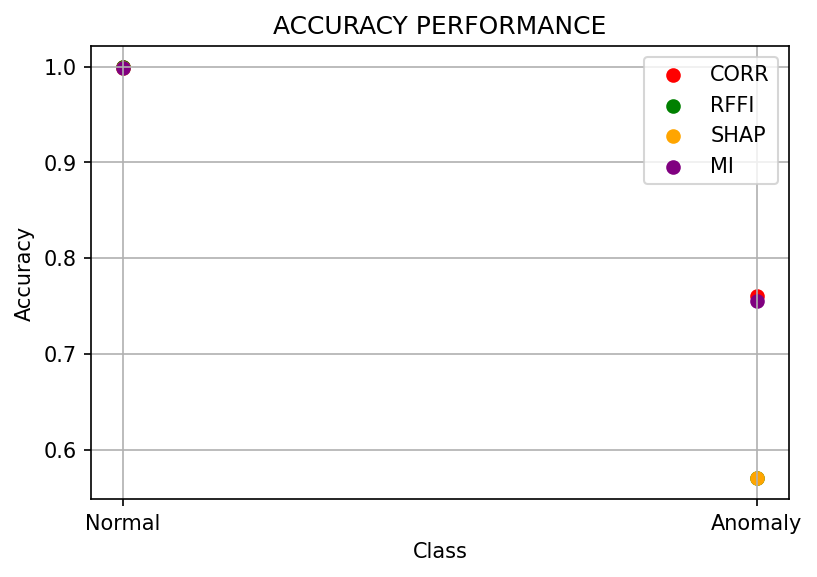

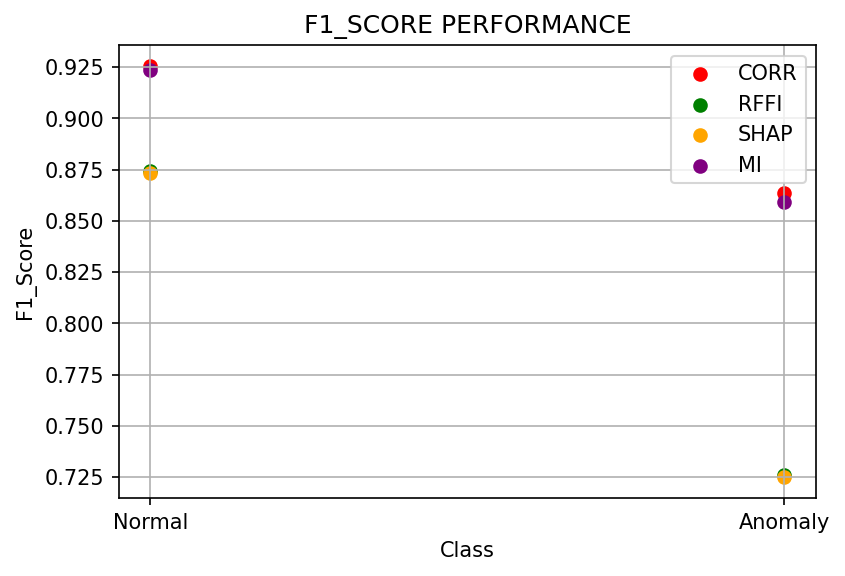

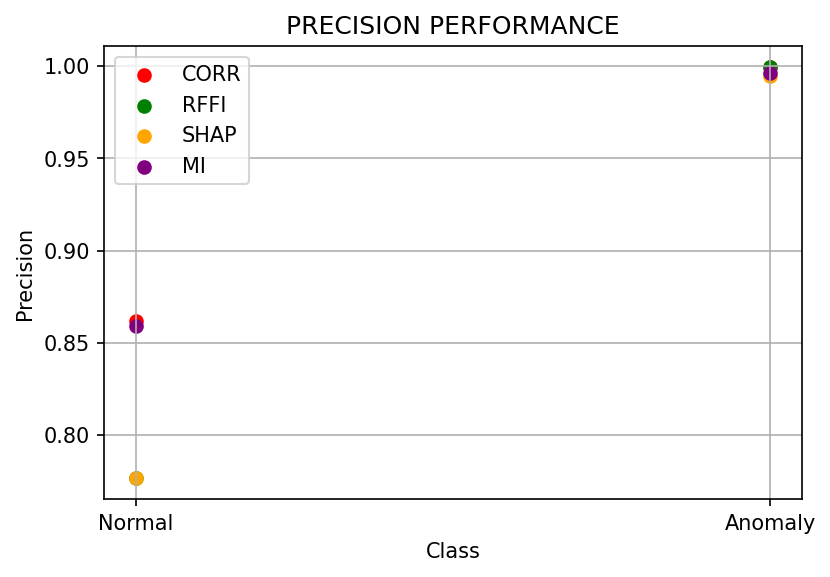

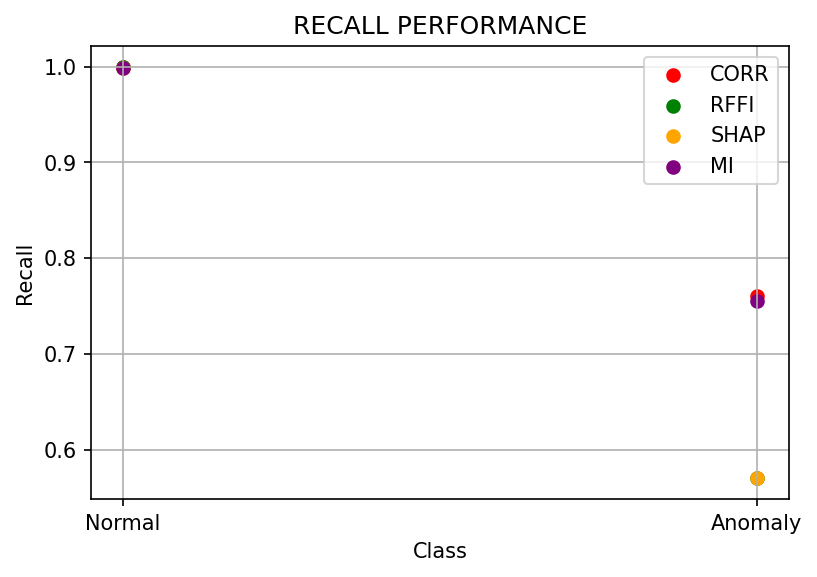

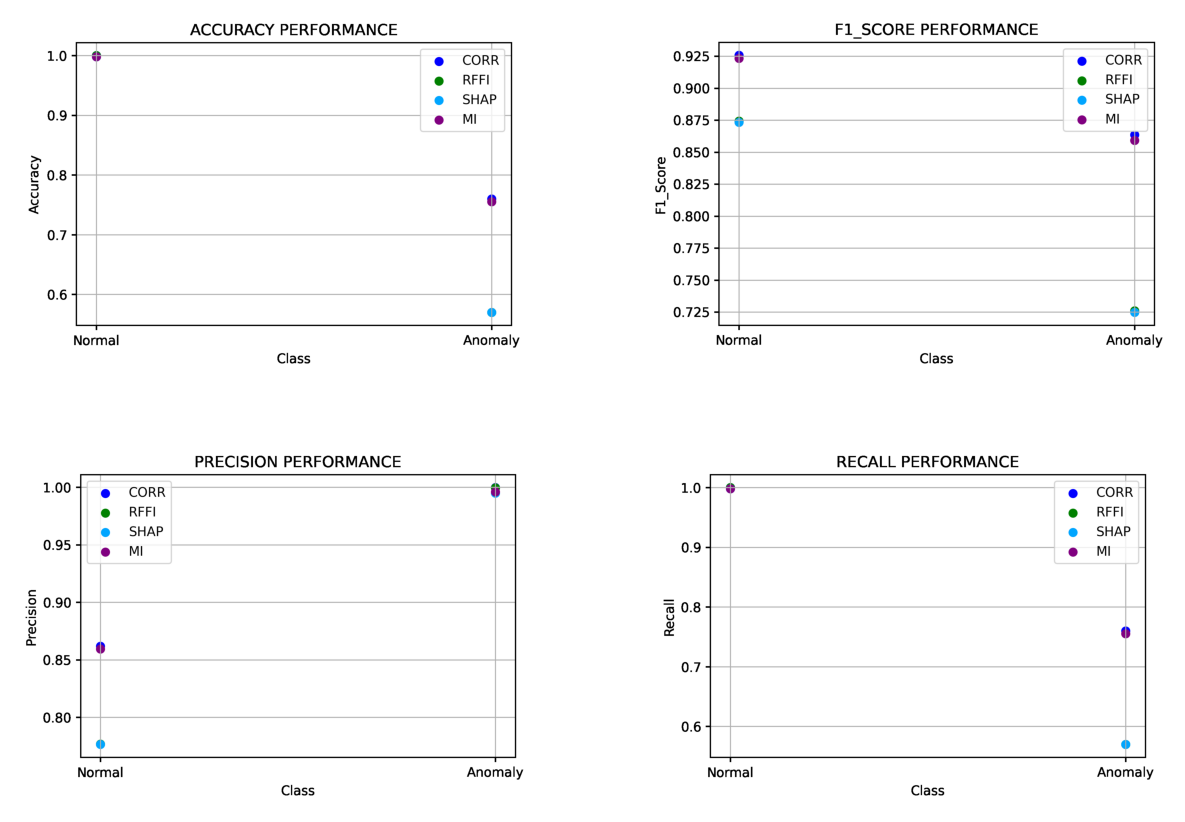

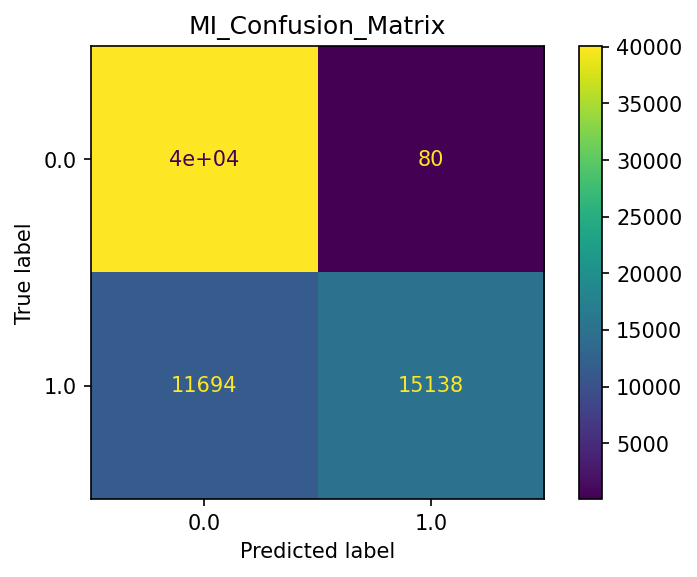

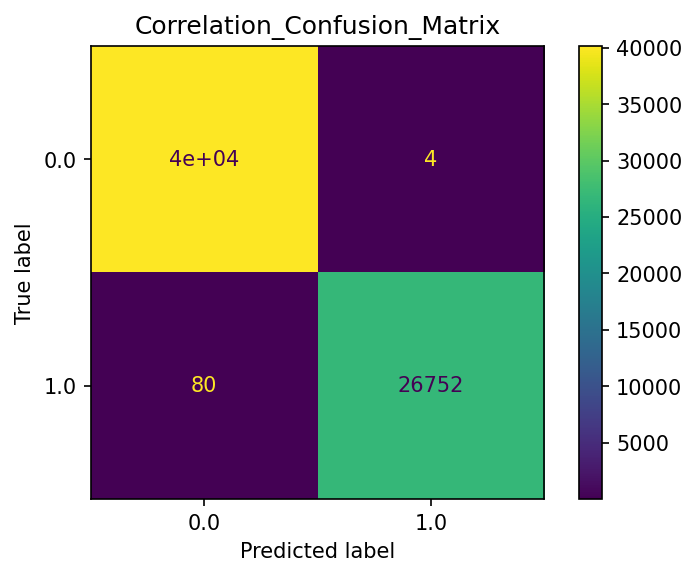

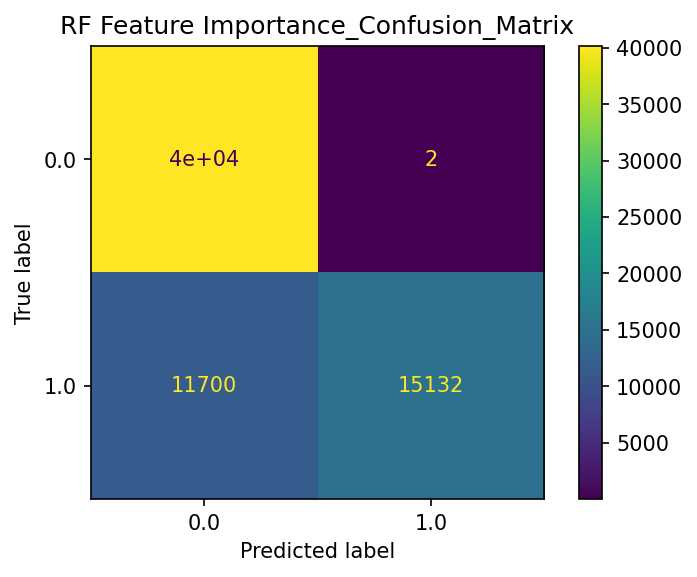

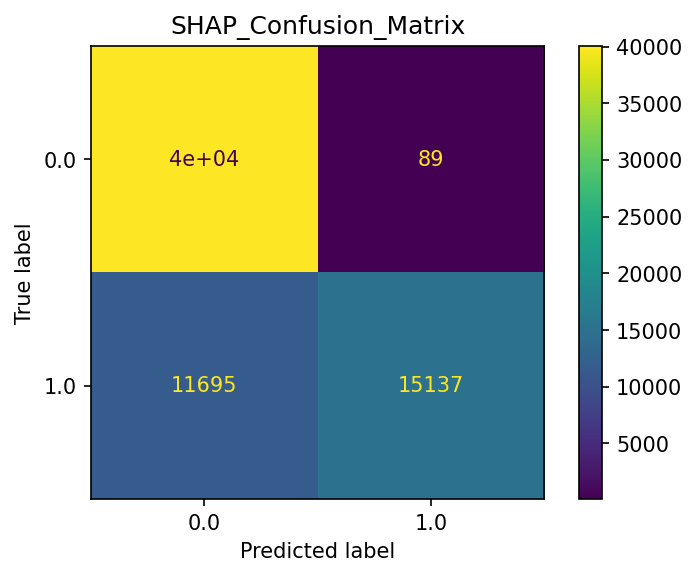

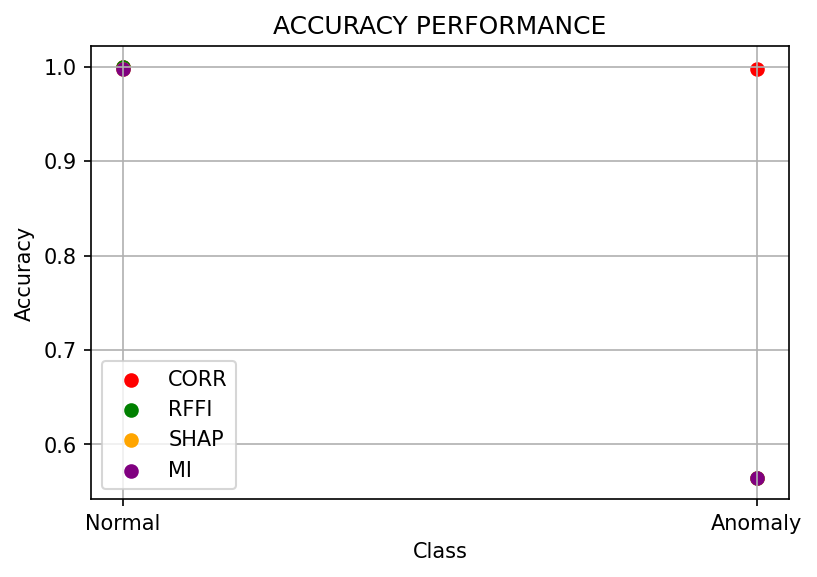

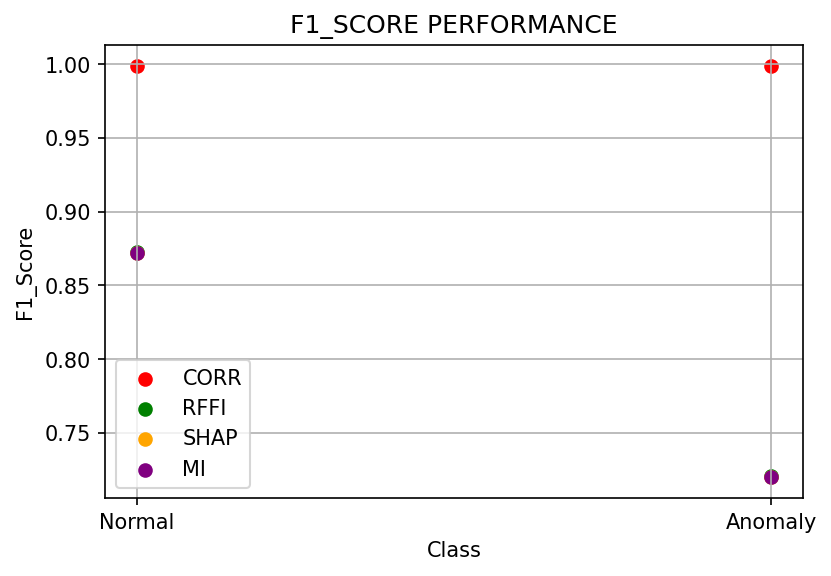

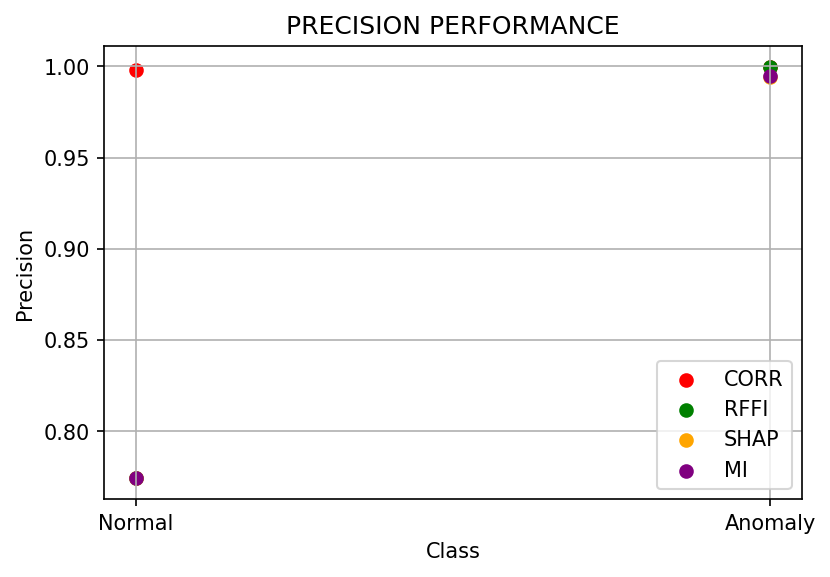

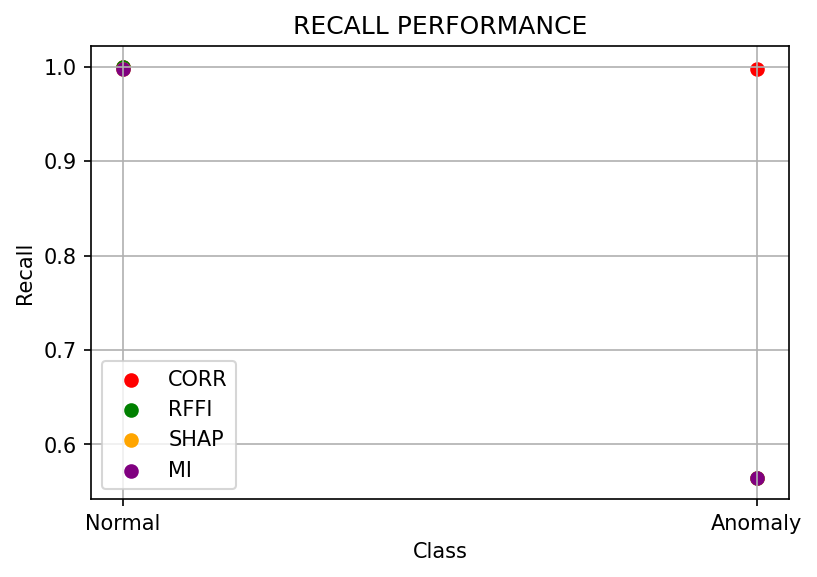

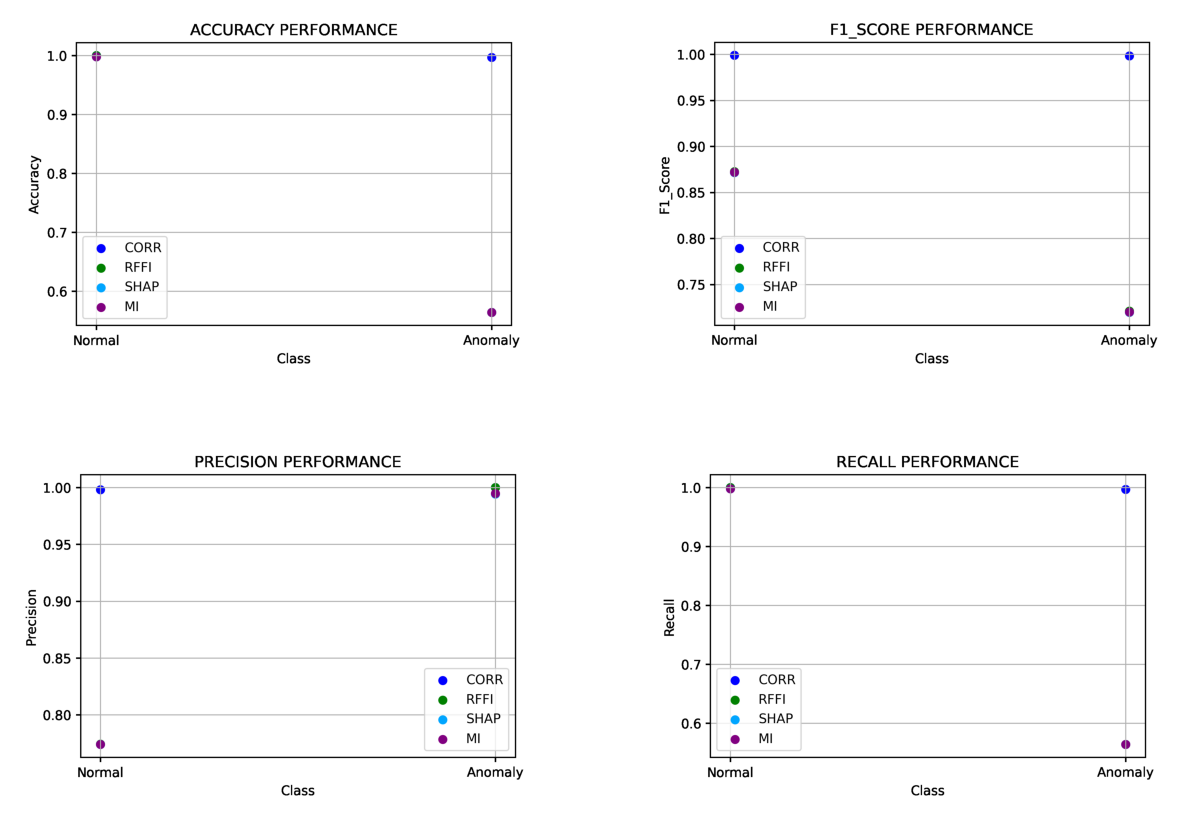

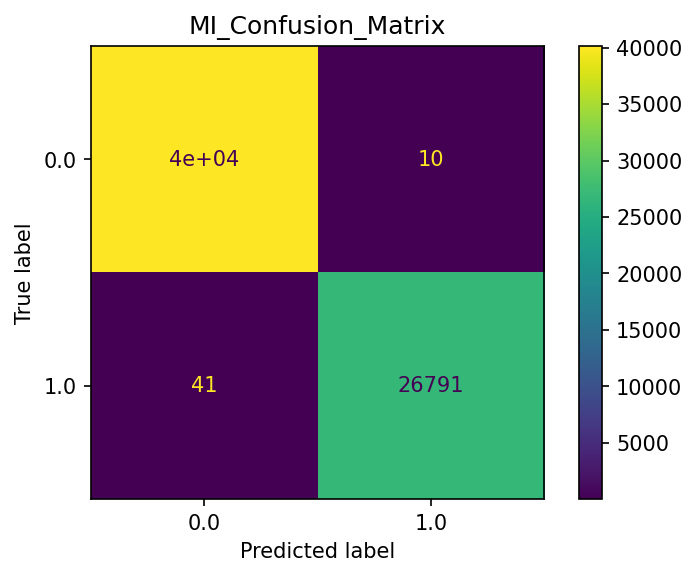

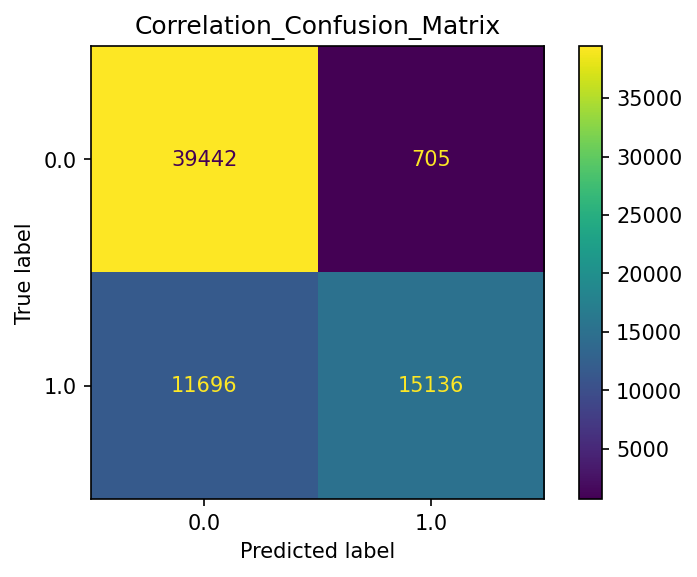

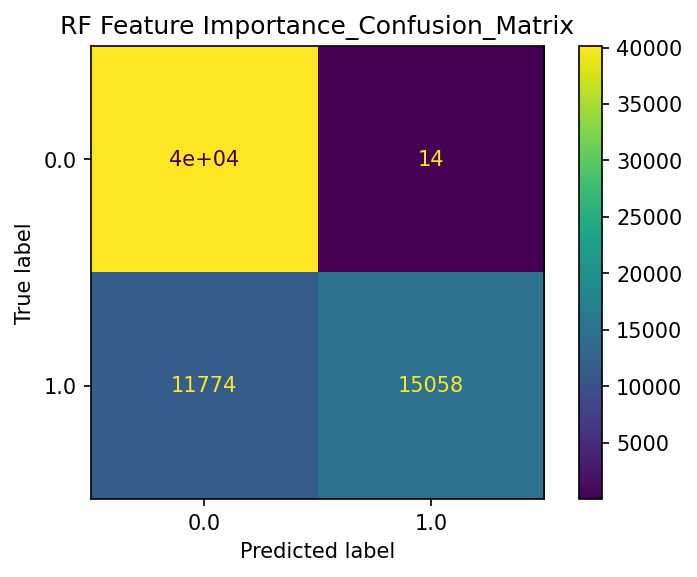

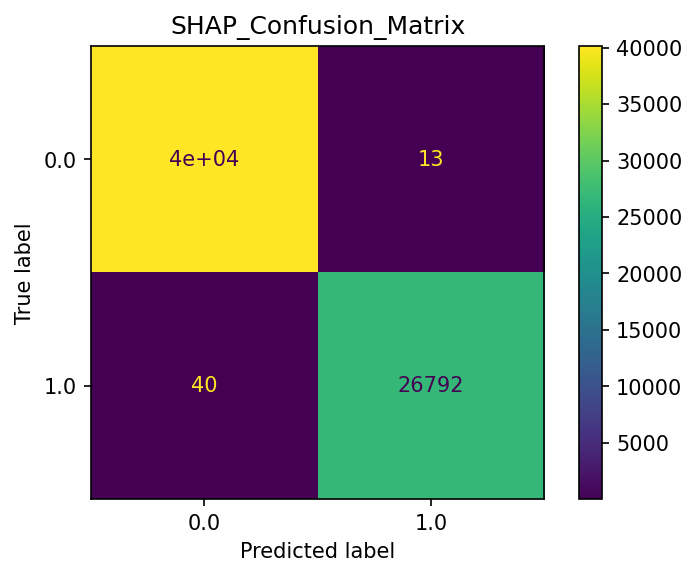

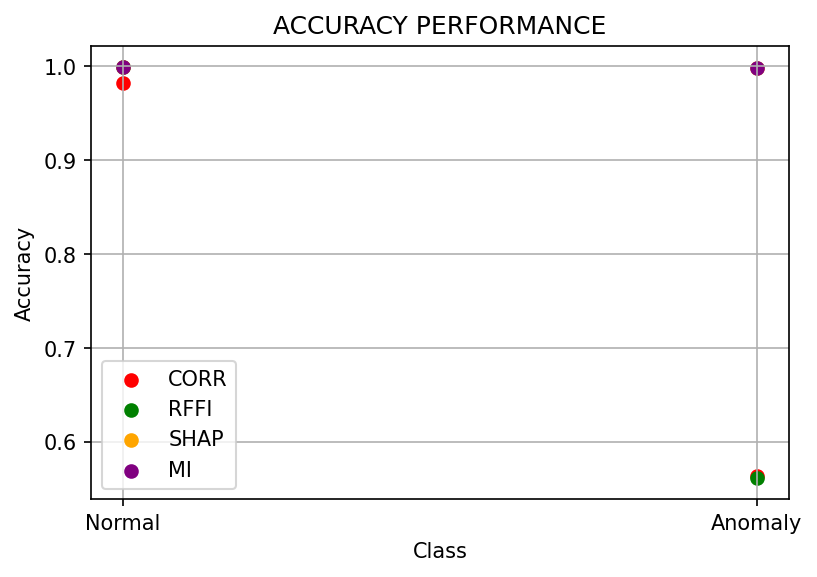

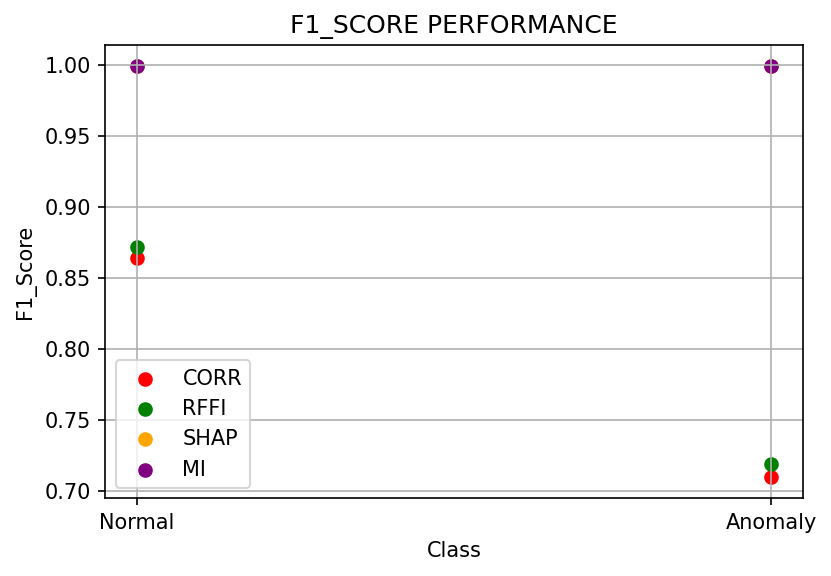

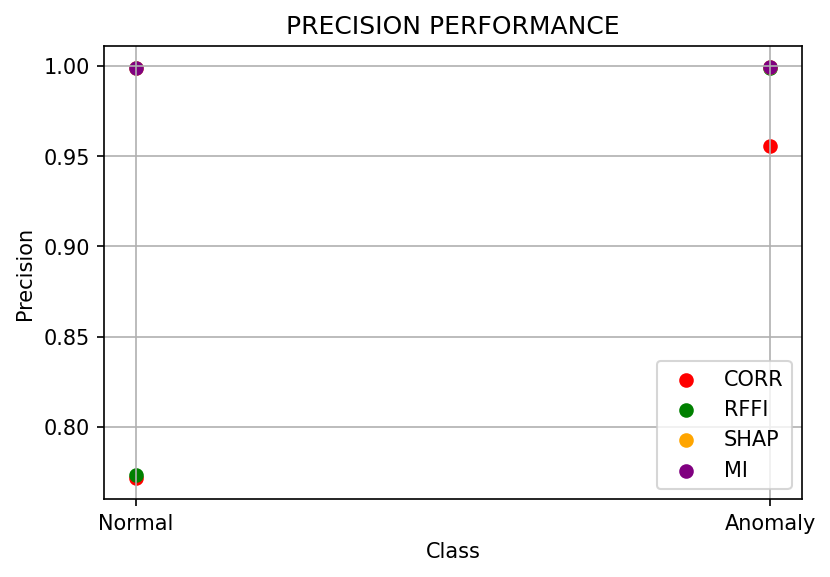

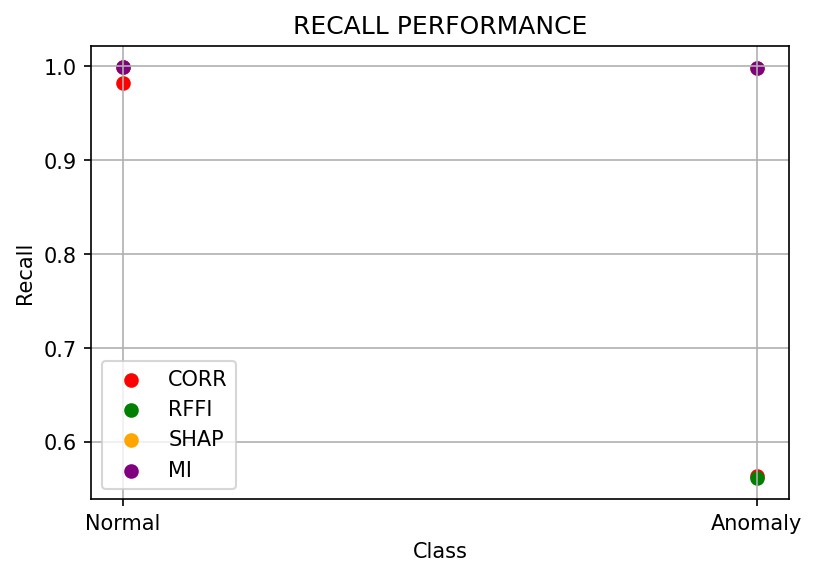

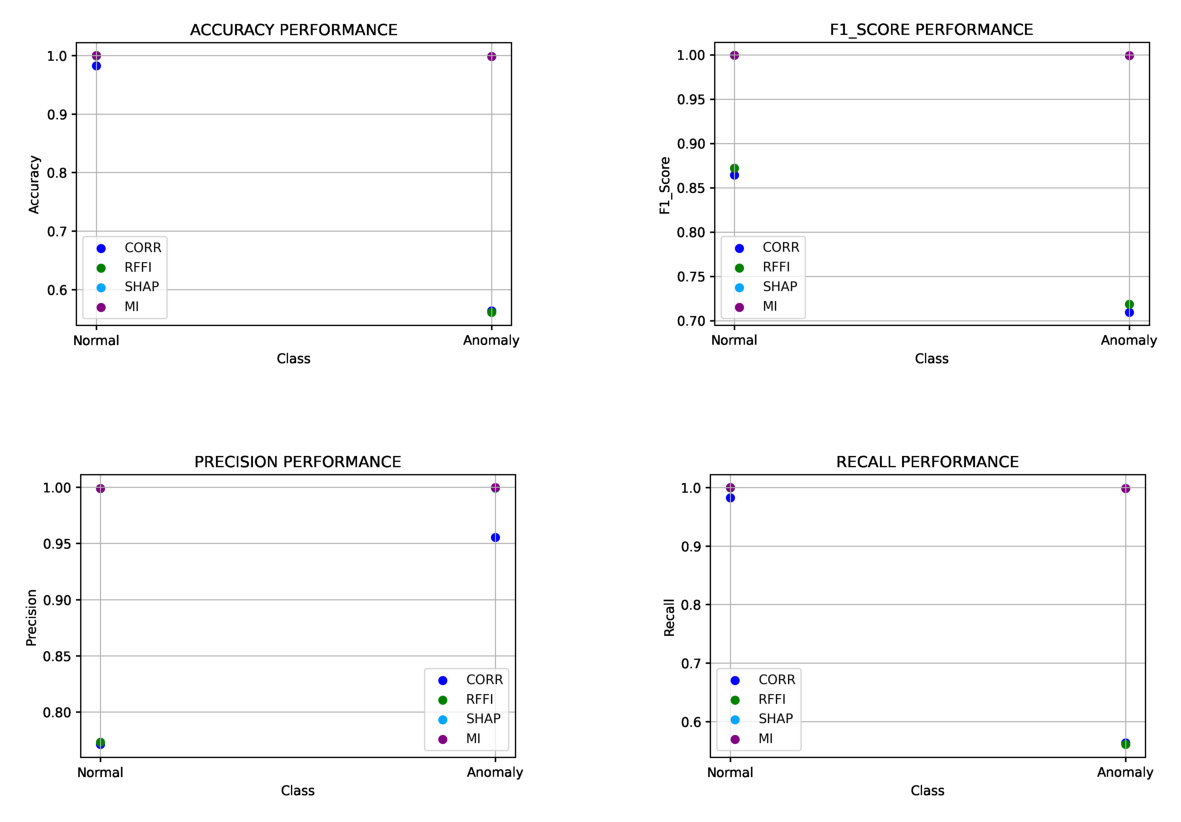

In [64]:
warnings.filterwarnings('ignore')

atype = 'BinaryClass'
dataset = 'UNSW'

k_list = [40,28,20,11]

for k in tqdm(k_list):
    
    print(f'Starting the Length of Features - {k}')

    MI_features = MI_topk_features(scaled_enc_df_train, k)
    CORR_features = CORR_topk_features(scaled_enc_df_train, k)
    RFFI_features = RFFI_topk_features(scaled_enc_df_train, k)

    NumberOfInstances = 3
    SHAP_features = SHAP_topk_features(scaled_enc_df_train, scaled_enc_df_test, NumberOfInstances, k)

    
    MI_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, MI_features, 'MI', k, atype, dataset)
    CORR_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, CORR_features, 'Correlation', k, atype)
    RFFI_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, RFFI_features, 'RF Feature Importance', k, atype)
    SHAP_performance = model_performance(scaled_enc_df_train, scaled_enc_df_test, SHAP_features, 'SHAP', k, atype)

    metrics = ['Accuracy', 'F1_Score', 'Precision', 'Recall']

    for metric in metrics:
        #Binary_Performance_BarChart(MI_performance, CORR_performance, RFFI_performance, SHAP_performance, metric,k,dataset)
        Binary_Performance_ScatterChart(MI_performance, CORR_performance, RFFI_performance, SHAP_performance, metric,k,dataset)

    i1 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Accuracy_Scatter.png')
    i2 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_F1_Score_Scatter.png')
    i3 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Precision_Scatter.png')
    i4 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Recall_Scatter.png')
    Binary_Summary_Plots(i1,i2,i3,i4, 'Scatter_Chart',k,dataset)

    # i1 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Accuracy_Bar.png')
    # i2 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_F1_Score_Bar.png')
    # i3 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Precision_Bar.png')
    # i4 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Recall_Bar.png')
    # Binary_Summary_Plots(i1,i2,i3,i4, 'Bar_Chart',k,dataset)

    # i1 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_MI_Confusion_Matrix.png')
    # i2 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_Correlation_Confusion_Matrix.png')
    # i3 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_RF Feature Importance_Confusion_Matrix.png')
    # i4 = str(f'visualization/Figures/{dataset}_Binary_k{str(k)}_SHAP_Confusion_Matrix.png')
    # Binary_Summary_Plots(i1,i2,i3,i4, 'Confusion_Matrix',k,dataset)

    print('---------------------------------------------------------------------------------------------')

In [9]:
data = {'FASTRNN': [0.9971,0.995,0.9975,0.996],
        'FastGRNN': [0.9971,0.995,0.9955,0.995],
        'SHAP+RF': [0.999176, 0.999260, 0.999093, 0.999209],
        'RFFI+RF': [0.795232, 0.886119, 0.780343, 0.823945],
        'CORR+RF': [0.7861, 0.863390, 0.773271, 0.814852], 
        'MI+RF': [0.999176, 0.999266, 0.999087, 0.999209]
        }

In [17]:
df = pd.DataFrame.from_dict(data,orient='index', columns=['F1-Score', 'Precision', 'Recall', 'Accuracy'])

<AxesSubplot:>

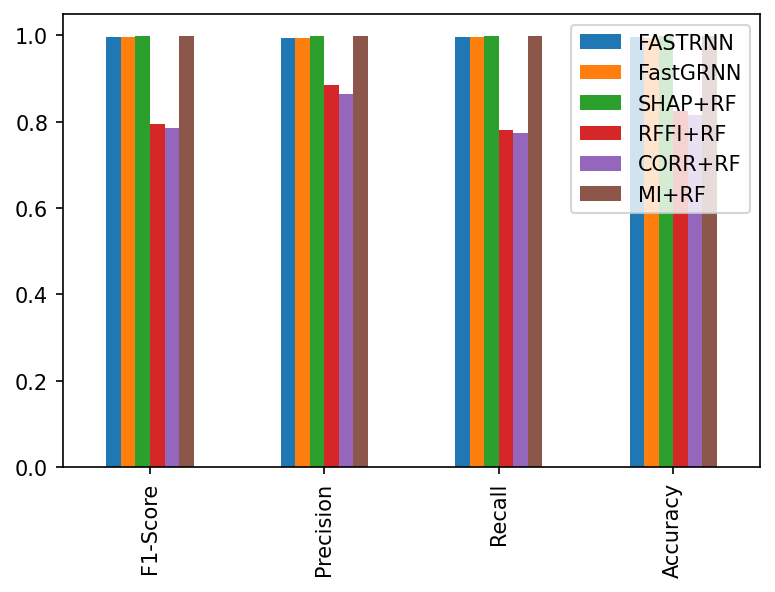

In [19]:
plt.rcParams['figure.dpi'] = 150
df.transpose().plot(kind='bar')

In [30]:
df

,F1-Score,Precision,Recall,Accuracy
FASTRNN,0.997100,0.995000,0.997500,0.996000
FastGRNN,0.997100,0.995000,0.995500,0.995000
SHAP+RF,0.999176,0.999260,0.999093,0.999209
RFFI+RF,0.795232,0.886119,0.780343,0.823945
CORR+RF,0.786100,0.863390,0.773271,0.814852
MI+RF,0.999176,0.999266,0.999087,0.999209


In [21]:
import plotly.express as px

In [42]:
px.bar(df, x=df.index, y=df['F1-Score'], color=df.index, text=df['F1-Score'], title="F1 Score Comparision", labels={'index': 'Techniques', 'F1-Score':'F1 Score'})

In [47]:
px.bar(df, x=df.index, y=df['Precision'], color=df.index, text=df['Precision'], title="Precision Score Comparision", labels={'index': 'Techniques'})

In [48]:
px.bar(df, x=df.index, y=df['Recall'], color=df.index, text=df['Recall'], title="Recall Score Comparision", labels={'index': 'Techniques'})

In [49]:
px.bar(df, x=df.index, y=df['Accuracy'], color=df.index, text=df['Accuracy'], title="Accuracy Score Comparision", labels={'index': 'Techniques'})

In [54]:
df_UNSW = pd.read_csv('../Data/UNSW_NB15_training-set.csv')

Text(0.5, 1.0, 'Attack Type Count Distribution')

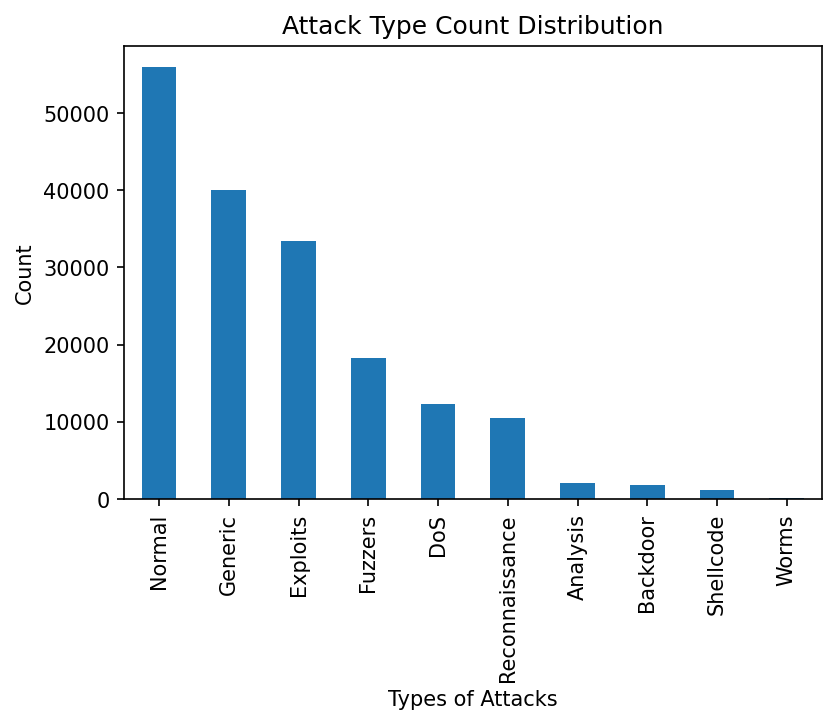

In [59]:
df_UNSW['attack_cat'].value_counts().plot(kind='bar')
plt.xlabel('Types of Attacks')
plt.ylabel('Count')
plt.title('Attack Type Count Distribution')

In [60]:
df_UNSW['attack_cat'].value_counts().index

Index(['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance',
       'Analysis', 'Backdoor', 'Shellcode', 'Worms'],
      dtype='object')